In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/africa-economic-banking-and-systemic-crisis-data/african_crises.csv


# 1. Overview of the dataset

### context
This dataset is a derivative of Reinhart et. al's Global Financial Stability dataset which can be found online at: https://www.hbs.edu/behavioral-finance-and-financial-stability/data/Pages/global.aspx

The dataset will be valuable to those who seek to understand the dynamics of financial stability within the African context.

### content
The dataset specifically focuses on the Banking, Debt, Financial, Inflation and Systemic Crises that occurred, from 1860 to 2014, in 13 African countries, including: Algeria, Angola, Central African Republic, Ivory Coast, Egypt, Kenya, Mauritius, Morocco, Nigeria, South Africa, Tunisia, Zambia and Zimbabwe.

### motivation
My inspiration stems from the following: 

i) How were the 13 African countries affected by the debt defaults and the crises from 1860 to 2014?

ii) What was the debt defaults and crises situation in the African Countries Before and after Independence?

iii) Which factors are most associated with Banking Crises in Africa? 

iv) Model building to predict Banking Crisis in African countries.

v) Time series additive model to model the seasonal variation (seasonality or cycles that repeat regularly over time) in the exchange rate in USD between 1860 to 2014.


### Loading necessary libraries

In [2]:
import pandas as pd
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

from statsmodels.formula.api import logit
from numpy import polyfit
import warnings
warnings.filterwarnings("ignore")
import itertools
from sklearn.preprocessing import MinMaxScaler


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score
from sklearn.metrics import precision_score, recall_score,roc_auc_score,roc_curve, auc 


# 2. Dataset Loading & Description

In [3]:
df = pd.read_csv('../input/africa-economic-banking-and-systemic-crisis-data/african_crises.csv')

In [4]:
print('African_crisis dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')
print("Columns names are \n {}".format(df.columns))

African_crisis dataset has 1059 rows, and 14 columns
Columns names are 
 Index(['case', 'cc3', 'country', 'year', 'systemic_crisis', 'exch_usd',
       'domestic_debt_in_default', 'sovereign_external_debt_default',
       'gdp_weighted_default', 'inflation_annual_cpi', 'independence',
       'currency_crises', 'inflation_crises', 'banking_crisis'],
      dtype='object')


In [5]:
df.sample(5)

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
780,56,ZAF,South Africa,1972,0,7.394000e-01,0,0,0.0,8.431511,1,0,0,no_crisis
359,19,EGY,Egypt,1936,0,1.987000e-01,0,0,0.0,-7.249727,1,0,0,no_crisis
364,19,EGY,Egypt,1941,0,2.416000e-01,0,0,0.0,24.188188,1,0,1,no_crisis
947,69,ZMB,Zambia,1993,0,5.610000e-01,0,1,0.0,183.263000,1,1,1,no_crisis
1019,70,ZWE,Zimbabwe,1974,0,5.490000e-27,1,1,0.0,6.596093,1,0,0,no_crisis


### Variables
i) systemic_crisis : "0" means that no systemic crisis occurred in the year and "1" means that a systemic crisis occurred in the year.

ii) exch_usd : The exchange rate of the country vis-a-vis the USD.

iii) domestic_debt_in_default : "0" means that no sovereign domestic debt default occurred in the year and "1" means that a sovereign domestic debt default occurred in the year.

iv) sovereign_external_debt_default : "0" means that no sovereign external debt default occurred in the year and "1" means that a sovereign external debt default occurred in the year.

v) gdp_weighted_default : The total debt in default vis-a-vis the GDP.

vi) inflation_annual_cpi : The annual CPI Inflation rate.

vii) independence : "0" means "no independence" and "1" means "independence".

viii) currency_crises : "0" means that no currency crisis occurred in the year and "1" means that a currency crisis occurred in the year.

ix) inflation_crises : "0" means that no inflation crisis occurred in the year and "1" means that an inflation crisis occurred in the year.

x) banking_crisis : "no_crisis" means that no banking crisis occurred in the year and "crisis" means that a banking crisis occurred in the year.

# 3. Data Exploration

##### Is there any missing value?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case                             1059 non-null   int64  
 1   cc3                              1059 non-null   object 
 2   country                          1059 non-null   object 
 3   year                             1059 non-null   int64  
 4   systemic_crisis                  1059 non-null   int64  
 5   exch_usd                         1059 non-null   float64
 6   domestic_debt_in_default         1059 non-null   int64  
 7   sovereign_external_debt_default  1059 non-null   int64  
 8   gdp_weighted_default             1059 non-null   float64
 9   inflation_annual_cpi             1059 non-null   float64
 10  independence                     1059 non-null   int64  
 11  currency_crises                  1059 non-null   int64  
 12  inflation_crises    

##### Result Interpretation;

* There is no missing value in the dataset

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
case,1059.0,35.613787,23.692402,1.000000,15.000000,38.00000,56.000000,7.000000e+01
year,1059.0,1967.767705,33.530632,1860.000000,1951.000000,1973.00000,1994.000000,2.014000e+03
systemic_crisis,1059.0,0.077432,0.267401,0.000000,0.000000,0.00000,0.000000,1.000000e+00
exch_usd,1059.0,43.140831,111.475380,0.000000,0.195350,0.86840,8.462750,7.443061e+02
domestic_debt_in_default,1059.0,0.039660,0.195251,0.000000,0.000000,0.00000,0.000000,1.000000e+00
sovereign_external_debt_default,1059.0,0.152975,0.360133,0.000000,0.000000,0.00000,0.000000,1.000000e+00
gdp_weighted_default,1059.0,0.006402,0.043572,0.000000,0.000000,0.00000,0.000000,4.000000e-01
inflation_annual_cpi,1059.0,20848.892444,675727.429176,-28.502137,2.086162,5.76233,11.644048,2.198970e+07
independence,1059.0,0.776204,0.416984,0.000000,1.000000,1.00000,1.000000,1.000000e+00
currency_crises,1059.0,0.132200,0.349847,0.000000,0.000000,0.00000,0.000000,2.000000e+00


In [8]:
#Dropping case,cc3
df.drop(columns=['case','cc3'], axis=1, inplace=True)

#Coding banking_crisis to 0 and 1
labels = {'no_crisis': 0, 'crisis': 1}
df['banking_crisis'] = df['banking_crisis'].map(labels)

# Removing the label of 2 in currency crises as the variable should only have 2 lables 0 & 1
df['currency_crises'] = df['currency_crises'].replace(2,np.nan)
df = df.dropna()

##### How were the 13 African countries affected by the debt defaults and various crises between 1860 to 2014?

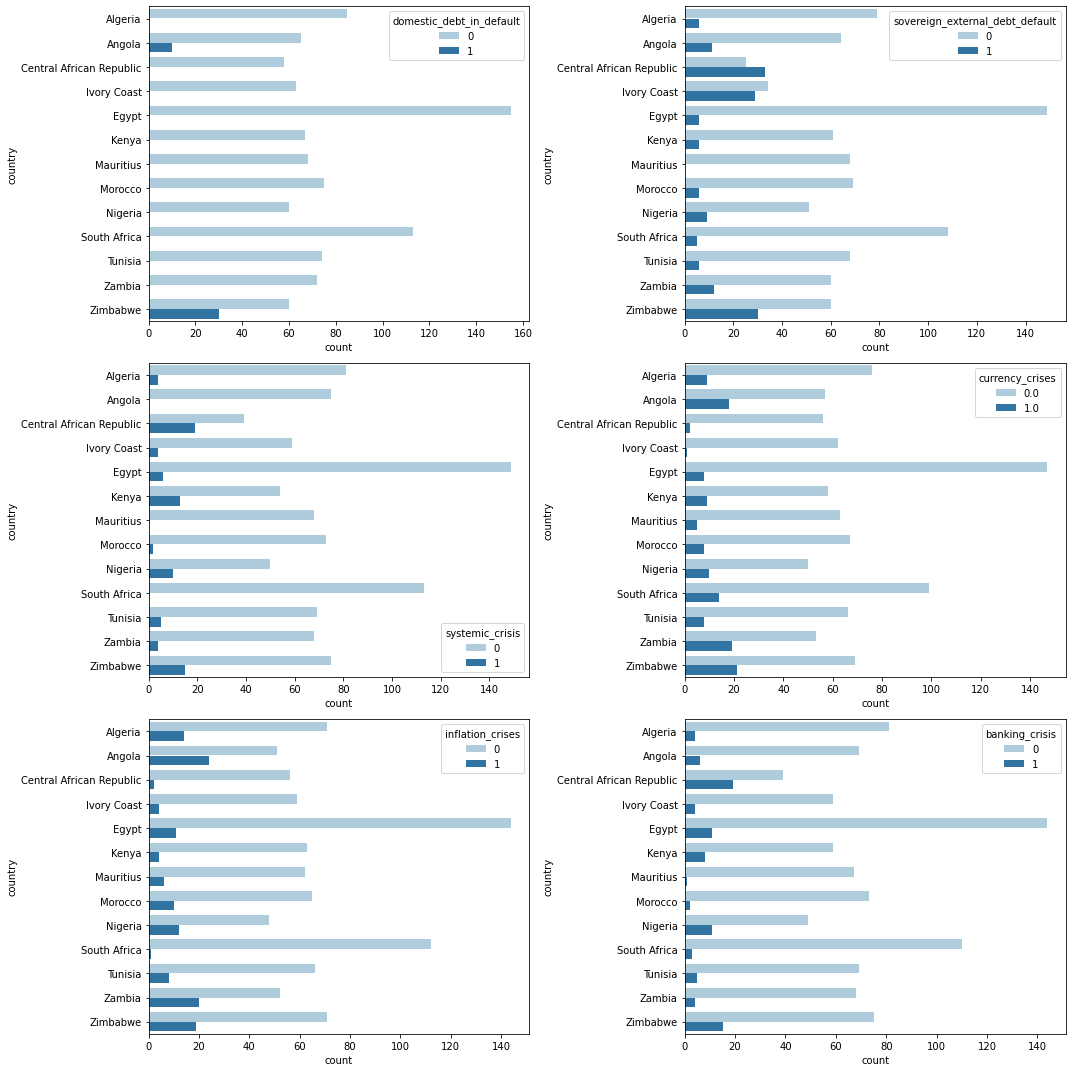

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
axes = axes.flatten()
cols = ['domestic_debt_in_default', 'sovereign_external_debt_default',
        'systemic_crisis','currency_crises', 'inflation_crises', 'banking_crisis']
for i, ax in zip(cols, axes):
  sns.countplot(y = 'country', ax = ax, data = df, hue = i, palette = 'Paired')
plt.tight_layout()
display()

#### Result Interpretation

###### From the Visualization:

**Independent Variables**

1) Domestic Debt in Default: Domestic debt is a central government's debt. It is debt issued by the lenders within the country (eg.Financial Institutions within the country). 
* Only 2 countries; Angola and Zimbabwe were in the Domestic Debt in Default between the years 1860 and 2014

2) Sovereign  External Debt Default: External debt is the portion of a country's debt that was borrowed from foreign lenders, including commercial banks, governments, or international financial institutions. These loans, including interest, must usually be paid in the currency in which the loan was made. To earn the needed currency, the borrowing country may sell and export goods to the lender's country. 
* All the countries except Mauritius suffered Sovereign  External Debt Default between the years 1860 and 2014. Countries that were affected the most include;Central African Republic, Ivory Coast and Zimbabwe.

3) Systemic Crisis: Systemic crisis is a domino effect in which a financial trouble spreads. between institutions and markets until it affects the whole monetary. and financial system with dire global economic consequences. 
* Between 1860 and 2014, all countries except Angola, Mauritius and South Africa were affected by Systemic Crisis. Most affected countries being Central African Republic,Zimbabwe,Kenya and Nigeria.

4) Currency Crisis: A currency crisis is a situation in which serious doubt exists as to whether a country's central bank has sufficient foreign exchange reserves to maintain the country's fixed exchange rate. The crisis is often accompanied by a speculative attack in the foreign exchange market. A currency crisis results from chronic balance of payments deficits, and thus is also called a balance of payments crisis. Often such a crisis culminates in a devaluation of the currency. 
* All countries were affected by Currency Crisis in that period and the most affected countries were Zimbabwe,Zambia,Angola,South Africa.

5) Inflation Crisis: Inflation is a quantitative measure of the rate at which the average price level of a basket of selected goods and services in an economy increases over a period of time. It is the constant rise in the general level of prices where a unit of currency buys less than it did in prior periods.   
* All the countries were affected by the Inflation crisis in that period; the most affected countries being Angola, Zambia, Zimbabwe, Algeria.

**Dependent Variable**

6) Banking Crisis: A banking crisis is often associated with financial crisis. It refers to a panic or a bank run during which investors sell off assets or withdraw money from savings accounts because they fear that the value of those assets will drop if they remain in a financial institution.
* Between the periods 1860 to 2014, all the countries suffered Banking Crisis and the most affected countries were;Central African Republic, Zimbabwe, Nigeria, Egypt and Kenya.

###### other observations;

* All the countries that suffered systemic crisis also suffered banking crisis. Central African Republic, Zimbabwe,Kenya and Nigeria had the highest count in each case at that time.
* Zimbabwe suffered all the debt defaults as well as crises in that period.

##### What was the debt defaults and crises situation in the African Countries Before and after Independence?

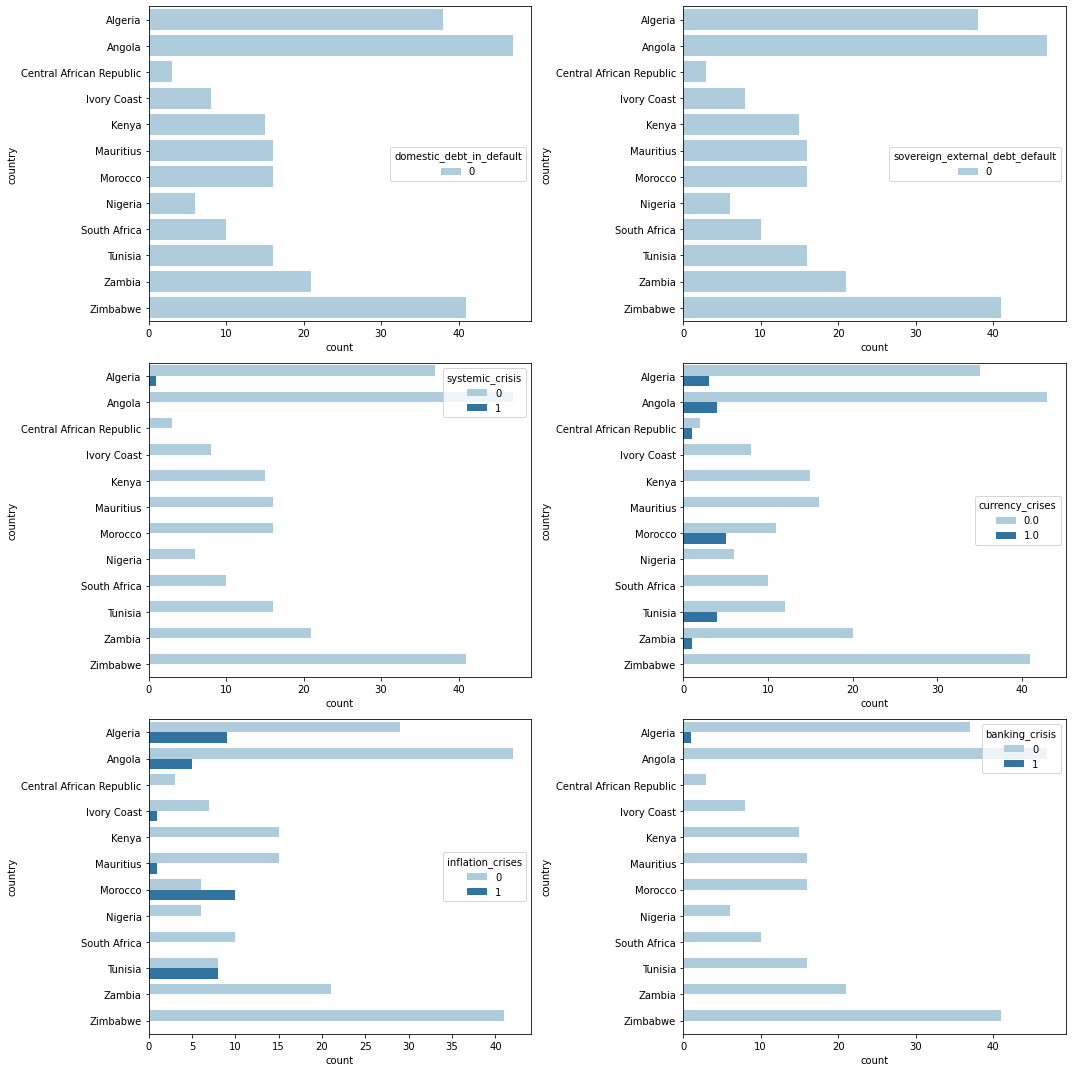

In [10]:
before_independence = df[df['independence']==0]
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
axes = axes.flatten()
cols = ['domestic_debt_in_default', 'sovereign_external_debt_default',
        'systemic_crisis','currency_crises', 'inflation_crises', 'banking_crisis']
for i, ax in zip(cols, axes):
  sns.countplot(y = 'country', ax = ax, data = before_independence, hue = i, palette = 'Paired')
plt.tight_layout()
display()

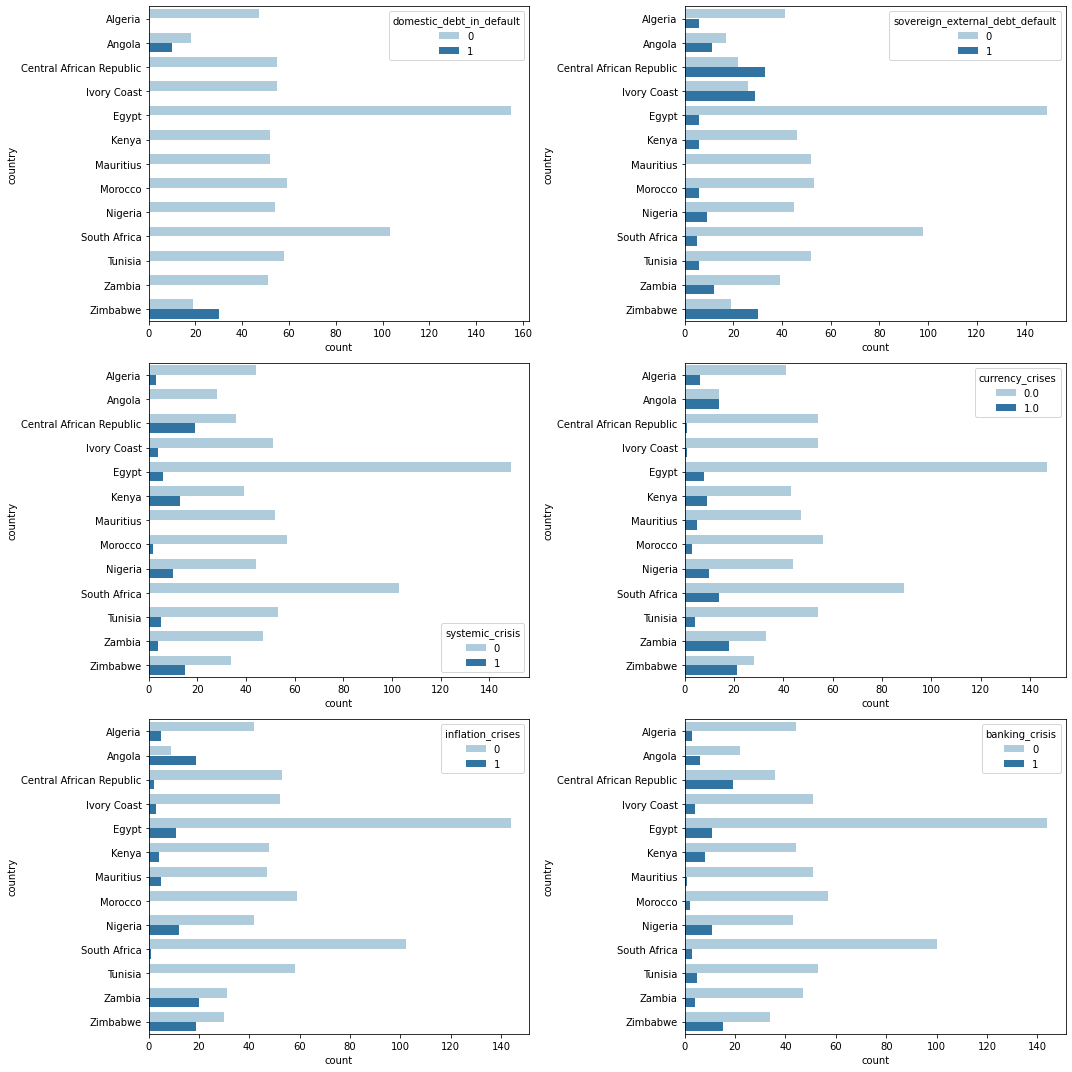

In [11]:
after_independence = df[df['independence']==1]
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
axes = axes.flatten()
cols = ['domestic_debt_in_default', 'sovereign_external_debt_default',
        'systemic_crisis','currency_crises', 'inflation_crises', 'banking_crisis']
for i, ax in zip(cols, axes):
  sns.countplot(y = 'country', ax = ax, data = after_independence, hue = i, palette = 'Paired')
plt.tight_layout()
display()

#### Result Interpretation

###### Observation Before and After independence

 1) After Independence was when most African countries started suffering Economic, Banking and Systemic Crises.
 
 2) Inflation and Currency crisis were the major forms of crises affecting some African countries before the independence, Inflation being the most and majorly affected Morocco, Algeria, Tunisia and Angola. These countries in contrast, recorded lowest count of crises and debt defaults after independence except Angola.
 
 3) Majority of the African Countries that had Banking crisis also had Systemic Crisis after independence. Most affected were Central Africa Republic,Zimbabwe,Kenya and Nigeria. 
 
 4) No country suffered either domestic or external debt defaults before independence but after independence, most countries suffered especially the external debt crisis most affected being Central Africa Republic, Ivory Coast, Zimbabwe, Zambia, Angola.
 
 5) Zimbabwe is the country that has majorly been affected by all the crises and debt defaults after the independence. This country on the other hand, never experienced any form of crisis or debt default before independence. 
 
 6) Mauritius is the only country that recorded the least count of the economic and banking crises before and after independence.


###### Which factors are mostly associated with Banking Crises in Africa? 
* Test of association (using correlation test) and statistical Significance (using Logistic Regression Test)

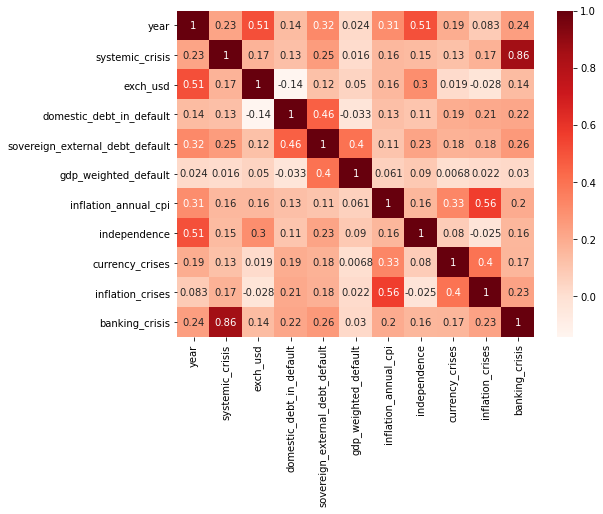

In [12]:
#Correlation Matrix
plt.figure(figsize=(8,6))
cor = df.corr(method='spearman')#Correlation with output variable
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Result Interpretation

###### From the correlation matrix;

1) All the features show a positive correlation with Banking crisis.

2) Banking crisis has a very strong Positive correlation with Systemic crisis.This explains why the African countries that were majorly affected by Banking crisis had suffered Systemic Crisis.

3) Apart from Systemic Crisis, Banking Crisis also shows strong positive correlation with Sovereign External Debt Default, domestic_debt_in_default,year, inflation_annual_cpi and Inflation Crisis.

###### Conclusion

* Banking Crisis is mostly associated with Systemic Crisis,Sovereign External Debt Default,year and Inflation Crisis. 

###### Is the relationship between Banking crisis and the related covariates statistically sifnificant?
* H0: The association between Banking Crisis and the other covariates is statistically significant
    
* H1: The association between Banking Crisis and the other covariates is not statistically significant

In [13]:
#Drop country since it is not numerical and systemic crisis because it has a strong positive correlation 
#with Banking Crisis hence might dominate.
df2 = df.drop(columns=['country','systemic_crisis'],axis = 1)
# Logistic Regression
crisis = logit("banking_crisis ~ year + exch_usd + sovereign_external_debt_default"
                   " + domestic_debt_in_default + currency_crises + gdp_weighted_default + independence"
                         "+ inflation_crises + inflation_annual_cpi", df2).fit()
print(crisis.summary())

Optimization terminated successfully.
         Current function value: 0.228492
         Iterations 19
                           Logit Regression Results                           
Dep. Variable:         banking_crisis   No. Observations:                 1055
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            9
Date:                Sun, 01 Nov 2020   Pseudo R-squ.:                  0.2339
Time:                        19:33:52   Log-Likelihood:                -241.06
converged:                       True   LL-Null:                       -314.64
Covariance Type:            nonrobust   LLR p-value:                 3.401e-27
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -42.4209     12.286     -3.453 

#### Result Interpretation

###### From the Logit Regression Results;

* The association between banking crisis and year, USD exchange rate, Independence and Inflation crisis is statistically significant (P-Value < 0.05).

* On the other hand,Sovereign external debt default, domestic debt in default, currency crises, gdp weighted default and inflation annual cpi have no significant association with banking crisis (P-Value > 0.05).

# 4. Model Building
#####  Model building to predict Banking Crisis in African countries.
###### Is there class imbalance?

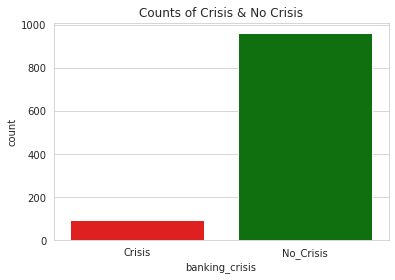

In [14]:
colors = ["r", "g"]
plt.figure(figsize=(6, 4))
sns.set_style('whitegrid')

x = df2.banking_crisis.replace(to_replace=[1, 0], value=['Crisis','No_Crisis'])
sns.countplot(x,palette=colors)
plt.title('Counts of Crisis & No Crisis')
plt.show()

#### Result Interpretation
###### From the Visualization;

* The data is highly imbalanced thus, the classifiers can be biased towards the majority class. 
* Changing the Classification threshhold is then needed. Upsampling method has been used to ensure a balanced class.

**Dealing with the Class Imbalance & Train/ Test Split**

In [15]:
no_crisis = df2[df2.banking_crisis == 0]
crisis = df2[df2.banking_crisis == 1]
from sklearn.utils import resample
# upsample minority
crisis_upsampled = resample(crisis,
                          replace=True, 
                          n_samples=len(no_crisis), 
                          random_state=123)
# combine majority and upsampled minority
upsampled = pd.concat([no_crisis, crisis_upsampled])
# check new class counts
upsampled.banking_crisis.value_counts()
y= upsampled.banking_crisis
X = upsampled.drop('banking_crisis', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y.value_counts()


1    962
0    962
Name: banking_crisis, dtype: int64

In [16]:
#Building 5 classifiers to obtain and use the one that makes the best predictions
classifiers = {
'LogisticRegression' : LogisticRegression(solver='liblinear'),
'RandomForest': RandomForestClassifier(),
'DecisionTreeClassifier': DecisionTreeClassifier(),
'SVM': SVC(),
'KNeighborsClassifier': KNeighborsClassifier(),
'GradientBoosting': GradientBoostingClassifier(),
}    

models_report = pd.DataFrame(columns = ['Model', 'Precision_score', 'Recall_score','F1_score', 'Accuracy'])
for classifier, classifier_name in zip(classifiers.values(), classifiers.keys()):
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    t = pd.Series({ 
                     'Model': classifier_name,
                     'Precision_score': precision_score(y_test, y_pred,average='macro'),
                     'Recall_score': recall_score(y_test, y_pred,average='macro'),
                     'F1_score': f1_score(y_test, y_pred,average='macro'),
                     'Accuracy': accuracy_score(y_test, y_pred)}
                   )
    models_report = models_report.append(t, ignore_index = True)
models_report

,Model,Precision_score,Recall_score,F1_score,Accuracy
0,LogisticRegression,0.766421,0.751013,0.745017,0.748052
1,RandomForest,0.985222,0.984043,0.984392,0.984416
2,DecisionTreeClassifier,0.973558,0.970745,0.971351,0.971429
3,SVM,0.747368,0.512690,0.355738,0.501299
4,KNeighborsClassifier,0.943694,0.933511,0.934555,0.935065
5,GradientBoosting,0.954125,0.949711,0.950457,0.950649


In [17]:
#5-Fold Cross Validation
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
    

Classifiers:  LogisticRegression Has a training score of 73.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 98.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 97.0 % accuracy score
Classifiers:  SVC Has a training score of 51.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  GradientBoostingClassifier Has a training score of 95.0 % accuracy score


In [18]:
#Hyperparameter tuning using Gridsearch
# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'solver' : ['lbfgs', 'liblinear'] }
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(5,7,1)), 
              "min_samples_leaf": list(range(2,4,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# DecisionTree best estimator
tree_clf = grid_tree.best_estimator_
#Random Forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
grid_rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, n_iter = 100,  verbose=2, random_state=42, n_jobs = -1)
grid_rf_random.fit(X_train, y_train)
#Random Forest best estimator
rf_clf=grid_rf_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.0min finished


**Confusion Matrix**

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Logistic Regression**

Confusion matrix, without normalization
[[140  57]
 [ 27 161]]


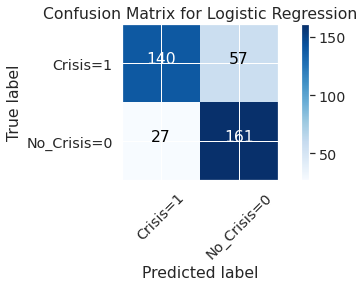

In [20]:
y_pred = log_reg.predict(X_test)
log_cnf_matrix = confusion_matrix(y_test,y_pred, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure(figsize=(7, 4))
sns.set(font_scale=1.3)
plot_confusion_matrix(log_cnf_matrix, 
                      classes=['Crisis=1','No_Crisis=0'],
              normalize= False,  
              title='Confusion Matrix for Logistic Regression')
plt.show()

**Decision Tree**

Confusion matrix, without normalization
[[197   0]
 [ 25 163]]


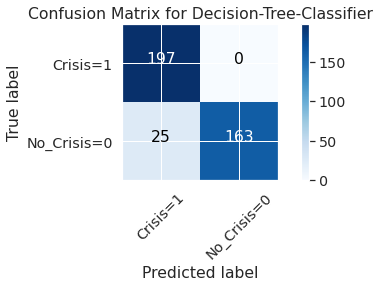

In [21]:
y_pred = tree_clf.predict(X_test)
Dtrees_cnf_matrix = confusion_matrix(y_test,y_pred, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure(figsize=(7, 4))
sns.set(font_scale=1.3)
plot_confusion_matrix(Dtrees_cnf_matrix, 
                      classes=['Crisis=1','No_Crisis=0'],
              normalize= False,  
              title='Confusion Matrix for Decision-Tree-Classifier')
plt.show()

**Random Forest**

Confusion matrix, without normalization
[[197   0]
 [  6 182]]


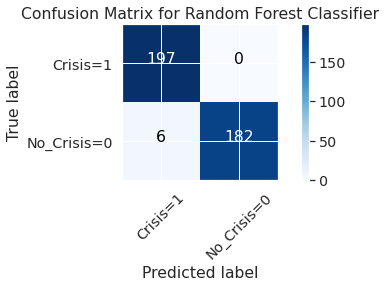

In [22]:
y_pred = rf_clf.predict(X_test)
rf_cnf_matrix = confusion_matrix(y_test,y_pred, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure(figsize=(7, 4))
sns.set(font_scale=1.3)
plot_confusion_matrix(rf_cnf_matrix, 
                      classes=['Crisis=1','No_Crisis=0'],
              normalize= False,  
              title='Confusion Matrix for Random Forest Classifier')
plt.show()

# 5. Time Series Additive Model
#### Time series additve model to model the seasonal variation (seasonality or cycles that repeat regularly over time)in the exchange rate in USD between 1860 to 2014.
###### How is the trend in USD Exchange Rates  in different countries before and after independence?

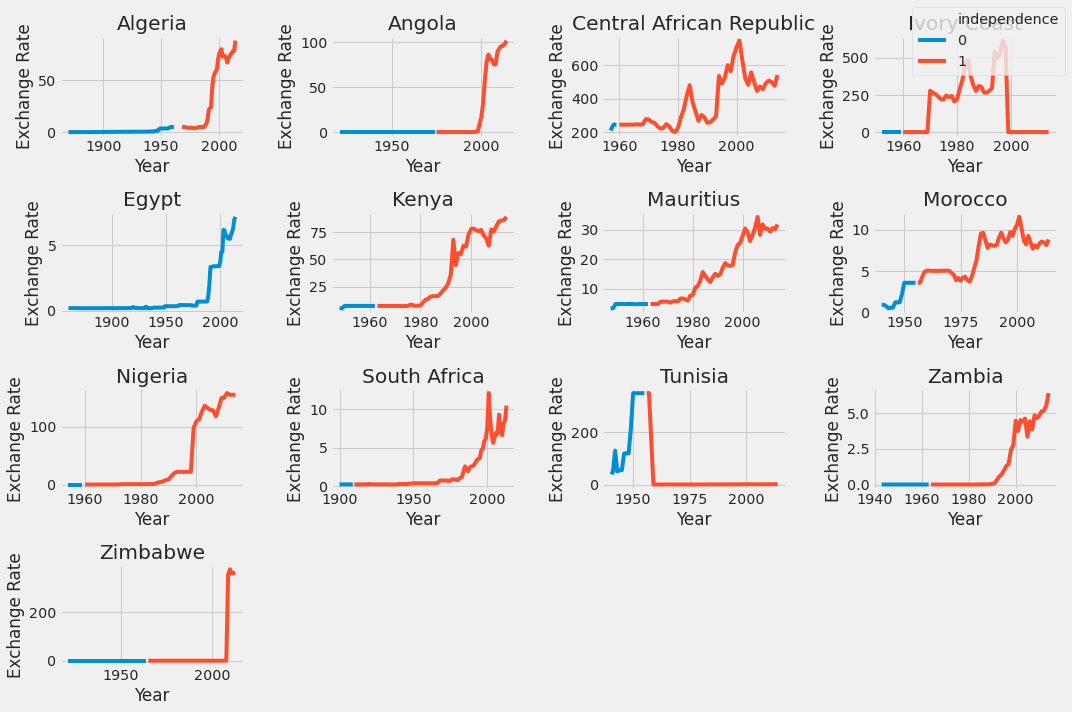

In [23]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,10))
axes = axes.flatten()
for i, ax in zip(df['country'].unique(), axes):
  sns.lineplot(x = 'year', y = 'exch_usd', hue = 'independence', 
               data = df[df['country'] == i], ax = ax)
  ax.set_xlabel('Year')
  ax.set_ylabel('Exchange Rate')
  ax.set_title('{}'.format(i))
  ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=1)
fig.subplots_adjust(top=0.95)
for i in range(13,16):
  fig.delaxes(axes[i])
plt.tight_layout()

##### Result Interpretation
 * Exchange Rates: An exchange rate is the value of one country's currency versus the currency of another country or economic zone. 
 
###### From the visualization of the exchange rate of the country vis-a-vis the USD;
 
The USD Exchange Rates were constant before independence in all countries except Morocco and Tunisia which had an increasing rate. On the other hand after independence, there was an increase in the exchange rates in all the african countries except Tunisia where there was a fall and Ivory Coast where the rates increased from 1970 and later fall in 2000.

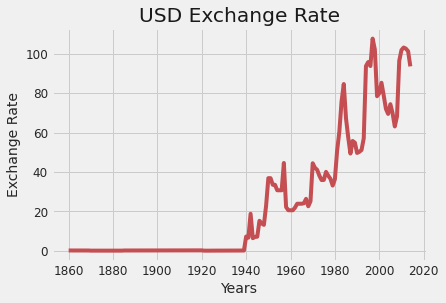

In [24]:
# Quick Visualization of the usd exchange rate in all the countries combined.
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
df1=df[['year','exch_usd']]
df2 = df1.groupby('year').mean()
plt.plot(df2.index, df2['exch_usd'], 'r')
plt.title('USD Exchange Rate')
plt.ylabel('Exchange Rate');
plt.xlabel('Years')
plt.show();

##### Is there seasonality component in the data

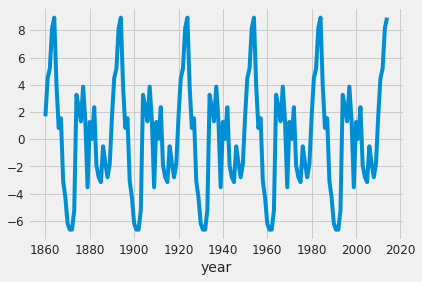

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
decomposition = seasonal_decompose(df2.exch_usd, freq=30, model='additive')
df2 = pd.DataFrame(data=df2.exch_usd, index=pd.date_range(start=datetime(1860,1,1), 
                                                              end = datetime(2014,1,1), freq='D'), columns=['exch_usd'])
seasonal_comp = decomposition.seasonal
fig = seasonal_comp.plot()
plt.show()



* The dataset shows a strong seasonality component

**Seasonal Adjustment with Modeling**

Coefficients: [ 5.79e-10  4.18e-08 -5.06e-05  6.46e-03 -2.69e-01  2.95e+00]


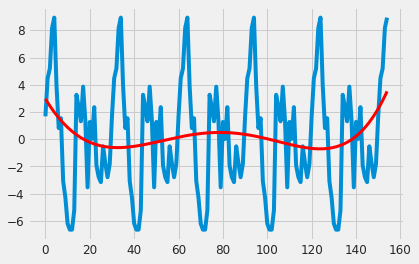

In [26]:
X = [i%365 for i in range(0, len(seasonal_comp))]
y = seasonal_comp.values
degree = 5
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(seasonal_comp.values)
plt.plot(curve, color='red', linewidth=3)
plt.show()

* Using the model to create a seasonally adjusted version of the exchange rate data

Coefficients: [ 2.65e-07 -8.10e-05  8.21e-03 -3.07e-01  3.14e+00]


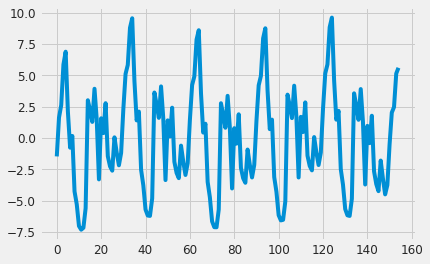

In [27]:
X = [i%365 for i in range(0, len(seasonal_comp))]
y = seasonal_comp.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# create seasonally adjusted
values = seasonal_comp.values
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
plt.plot(diff)
plt.show()

* References;

https://www.investopedia.com/